In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import sys
import datetime
import xgboost as xgb

In [4]:
sys.path.append('../..')
from data_engineering.shared import read_parquet_from_s3

In [21]:
ticker = 'AAPL'

loaded_model = xgb.Booster()
loaded_model.load_model('../models/xgb/xgboost_aapl_main-20231010-155338.json')

In [22]:
df = read_parquet_from_s3(ticker)
df.set_index('t', inplace=True)

actual_values = df['target'].dropna().values  # Store target values here before further modifications

df_embedded = df['embedded_text'].apply(pd.Series)
df_embedded = df_embedded.rename(columns=lambda x: 'embed_' + str(x))
df = pd.concat([df, df_embedded], axis=1)
df.drop('embedded_text', axis=1, inplace=True)
cols = list(df.columns)
cols.remove('target')
df = df[cols]

In [23]:
# Specify the number of days to predict
num_days_to_predict = 2
future_predictions = []
model_features = loaded_model.feature_names

# Generating predictions using XGBoost
last_data = df.iloc[-1:]

# Predictions loop
for _ in range(num_days_to_predict):
    data_to_predict = xgb.DMatrix(last_data)
    next_pred = loaded_model.predict(data_to_predict)
    future_predictions.append(next_pred[0])

    # shift up and update the last value with the new prediction
    last_data = last_data.shift(-1)
    last_data.iloc[-1, -1] = next_pred[0]  # assuming the value to predict is in the last column


# Generate future trading day timestamps
last_timestamp = df.index[-1]
nyse = mcal.get_calendar('NYSE')
future_business_days = nyse.valid_days(start_date=last_timestamp + datetime.timedelta(days=1), 
                                       end_date=last_timestamp + datetime.timedelta(days=num_days_to_predict * 2)).date
future_timestamps = future_business_days[:num_days_to_predict]

df_pred_with_original = df.copy()
for i, timestamp in enumerate(future_timestamps):
    df_pred_with_original.loc[timestamp] = [np.nan for _ in range(df.shape[1]-1)] + [future_predictions[i]]
    
predicted_values = df_pred_with_original.iloc[-num_days_to_predict:, -1].values

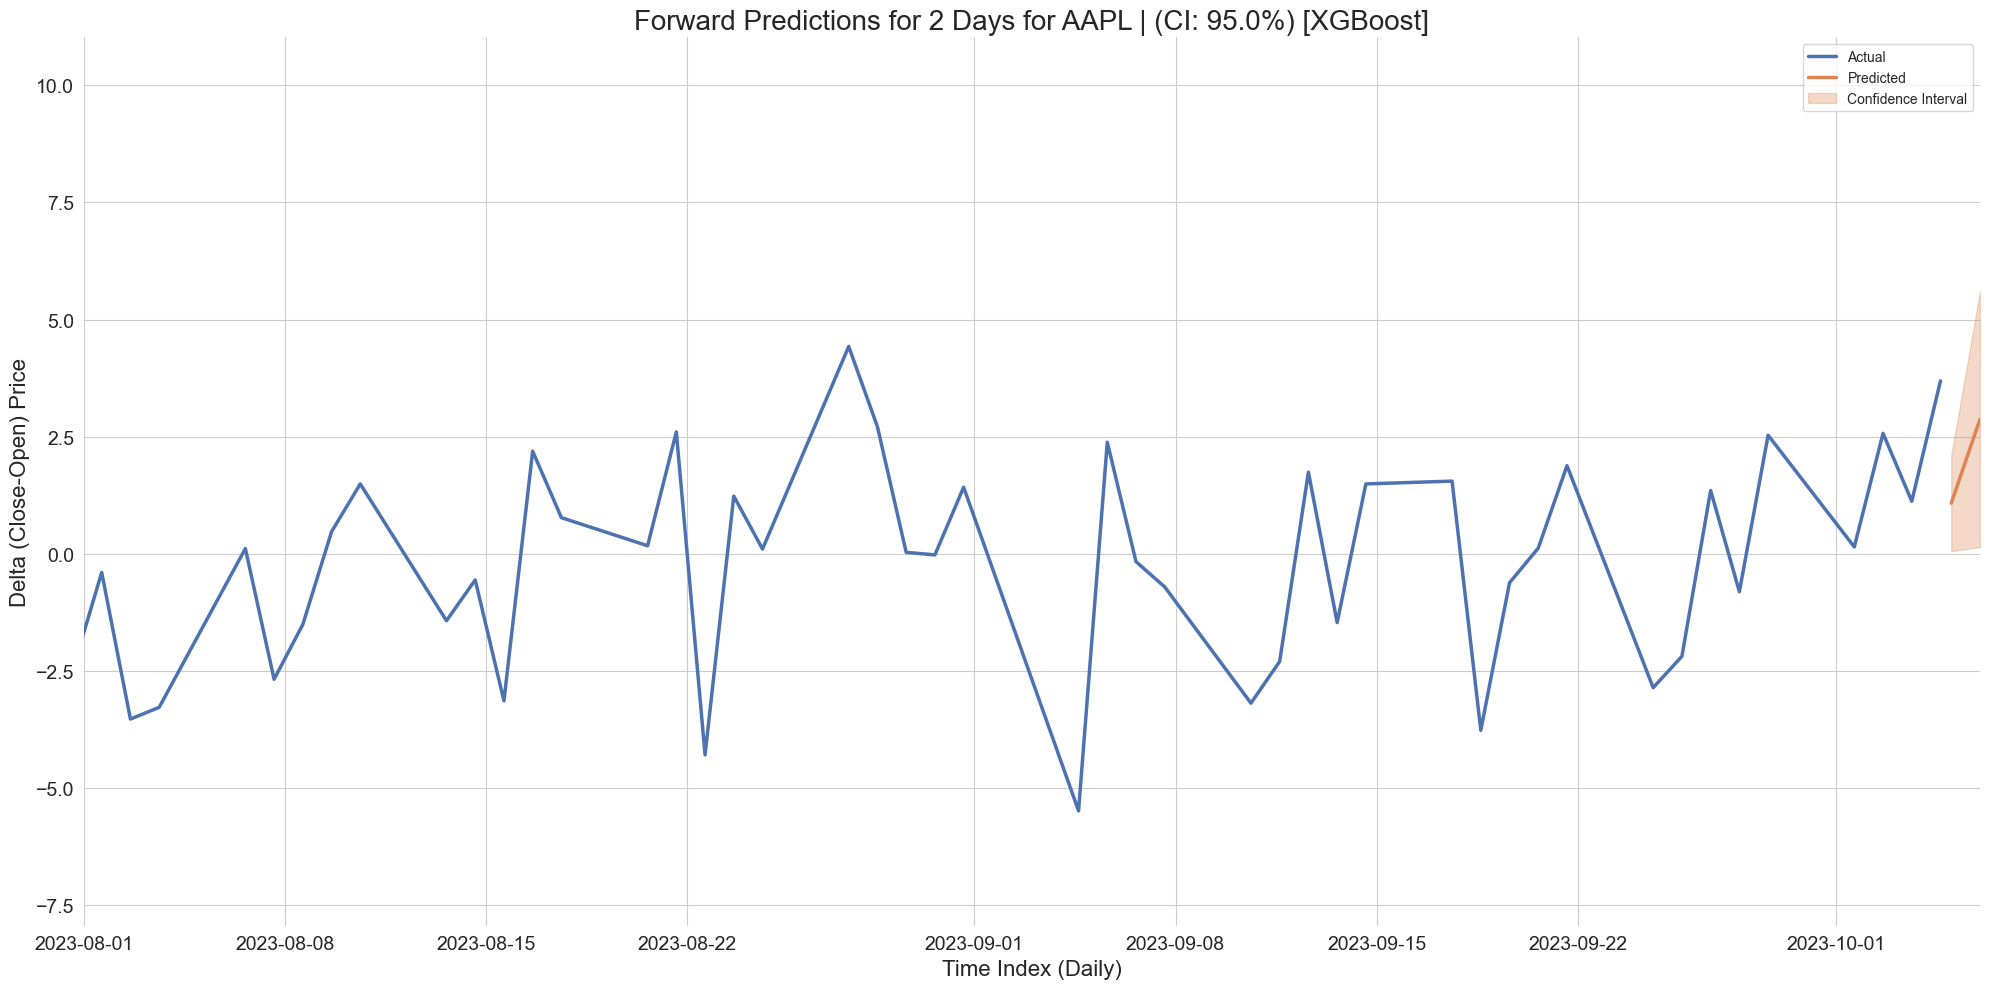

In [24]:
# Forecast Plot Configs
confidence_percentage = 0.95
zoom_start_timestamp = '2023-08-01'

lower_bound = predicted_values * (1 - confidence_percentage)
upper_bound = predicted_values * (1 + confidence_percentage)
start_date = datetime.datetime.strptime(zoom_start_timestamp, '%Y-%m-%d')

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))

blue = sns.color_palette("deep")[0]
orange = sns.color_palette("deep")[1]

sns.lineplot(x=df.index, y=actual_values, label='Actual', color=blue, linewidth=2.5)
sns.lineplot(x=future_timestamps, y=predicted_values, label='Predicted', color=orange, linewidth=2.5)
plt.fill_between(future_timestamps, lower_bound, upper_bound, color=orange, alpha=0.3, label='Confidence Interval')

plt.xlabel('Time Index (Daily)', fontsize=16)
plt.ylabel('Delta (Close-Open) Price', fontsize=16)
plt.legend(frameon=True, loc='upper right', fontsize='medium')
plt.title(f"Forward Predictions for {num_days_to_predict} Days for {ticker} | (CI: {confidence_percentage * 100}%) [XGBoost]", fontsize=20)

sns.despine(left=True, bottom=True)
plt.xlim(start_date, future_timestamps[-1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ticker = 'NVDA'

# loaded_model = xgb.Booster()
# loaded_model.load_model('../models/xgb/xgboost_nvda_main-20231010-161621.json')

# loaded_model_upper = xgb.Booster()
# loaded_model_upper.load_model('../models/xgb/xgboost_nvda_upper-20231010-161621.json')

# loaded_model_lower = xgb.Booster()
# loaded_model_lower.load_model('../models/xgb/xgboost_nvda_lower-20231010-161621.json')

# df = read_parquet_from_s3('AAPL')
# df.set_index('t', inplace=True)

# actual_values = df['target'].dropna().values

# df_embedded = df['embedded_text'].apply(pd.Series)
# df_embedded = df_embedded.rename(columns=lambda x: 'embed_' + str(x))
# df = pd.concat([df, df_embedded], axis=1)
# df.drop('embedded_text', axis=1, inplace=True)
# cols = list(df.columns)
# cols.remove('target')
# df = df[cols]

# # Predictions loop
# num_days_to_predict = 5
# future_predictions = []
# upper_predictions = []
# lower_predictions = []
# last_data = df.iloc[-1:].copy()

# model_features = loaded_model.feature_names

# for _ in range(num_days_to_predict):
#     data_to_predict = xgb.DMatrix(last_data[model_features])
    
#     next_pred = loaded_model.predict(data_to_predict)
#     next_pred_upper = loaded_model_upper.predict(data_to_predict)
#     next_pred_lower = loaded_model_lower.predict(data_to_predict)
    
#     future_predictions.append(next_pred[0])
#     upper_predictions.append(next_pred_upper[0])
#     lower_predictions.append(next_pred_lower[0])

#     new_row = last_data.iloc[0].copy()
#     new_row[-1] = next_pred[0]
#     last_data = pd.DataFrame([new_row], columns=last_data.columns)

# # Visualization
# last_timestamp = df.index[-1]
# nyse = mcal.get_calendar('NYSE')
# future_business_days = nyse.valid_days(start_date=last_timestamp + datetime.timedelta(days=1), 
#                                        end_date=last_timestamp + datetime.timedelta(days=num_days_to_predict * 2)).date
# future_timestamps = future_business_days[:num_days_to_predict]

# df_pred_with_original = df.copy()
# for i, timestamp in enumerate(future_timestamps):
#     df_pred_with_original.loc[timestamp] = [np.nan for _ in range(df.shape[1]-1)] + [future_predictions[i]]

# sns.set_style("whitegrid")
# plt.figure(figsize=(20, 10))

# blue = sns.color_palette("deep")[0]
# orange = sns.color_palette("deep")[1]

# sns.lineplot(x=df.index, y=actual_values, label='Actual', color=blue, linewidth=2.5)
# sns.lineplot(x=future_timestamps, y=future_predictions, label='Predicted', color=orange, linewidth=2.5)
# plt.fill_between(future_timestamps, lower_predictions, upper_predictions, color=orange, alpha=0.3, label='Confidence Interval')

# plt.xlabel('Time Index (Daily)', fontsize=16)
# plt.ylabel('Delta (Close-Open) Price', fontsize=16)
# plt.legend(frameon=True, loc='upper right', fontsize='medium')
# plt.title(f"Forward Predictions for {num_days_to_predict} Days for {ticker} [XGBoost]", fontsize=20)

# # Zoom in on a specific date range
# zoom_start_timestamp = '2023-08-01' 
# plt.xlim(pd.Timestamp(zoom_start_timestamp), future_timestamps[-1])

# sns.despine(left=True, bottom=True)
# plt.tight_layout()
# plt.show()